In [1]:
email_both = True
send_email = True

In [2]:
import pandas as pd
from xbbg import blp
import numpy as np
import matplotlib.pyplot as plt
import pytz
import time
from datetime import datetime, timedelta, date
from ipywidgets import HBox, RadioButtons, Button, Output
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.gridspec as gridspec
%matplotlib inline
import blpapi
import warnings
from blpapi import SessionOptions, Session, Request, CorrelationId
import threading
from concurrent.futures import ThreadPoolExecutor
import statsmodels.api as sm
import uuid
from pydataquery import DataQuery
import os
import win32com.client
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# warnings.filterwarnings("ignore")

In [3]:
# df = pd.read_excel("New BBG Data.xlsx",index_col=0, parse_dates=True)
# df1 = pd.read_excel("BBG Data.xlsx",index_col=0, parse_dates=True)
# df2 = pd.concat([df,df1]).sort_index().drop_duplicates().ffill().between_time("07:30","11:59")
# df2.to_excel("BBG Data v2.xlsx")

In [4]:
x = blp.bdp(tickers=["CDX IG CDSI GEN 5Y CORP","ITRX EUR CDSI GEN 5Y CORP"], flds="ROLLING_SERIES").copy()
ig = x.iloc[0,0]
main = x.iloc[1,0]
ig_series = f"CDX IG CDSI S{ig} 5Y CORP"
main_series = f"ITRX EUR CDSI S{main} 5Y CORP"

df = pd.read_excel("BBG Data v2.xlsx",index_col=0, parse_dates=True)
bbg_datafile = df.copy()
last_update = df.dropna().index[-1]
all_bbg_tickers = [ig_series, main_series, "V2X INDEX", "VIX INDEX", 'GBTPGR10 Index', 'GFRN10 Index', 'GDBR10 Index']
new_data = pd.DataFrame()

for bbg_tickers in all_bbg_tickers:
    bbg_date = pd.to_datetime(last_update.date())
    data = None
    while True:
        try:
            f = blp.bdib(ticker = bbg_tickers, dt = bbg_date, interval = 1, ref='IndexYieldCurve')      
        except:
            if bbg_date > pd.to_datetime(datetime.now().date()):
                break
        data = pd.concat([data,f])
        bbg_date += timedelta(days=1)    
    try:
        data = data.iloc[:,[3]].copy()
        data.columns = [bbg_tickers]
    except:
        continue
    new_data = pd.concat([new_data, data],axis=1)

new_data.index = new_data.index.tz_convert('America/New_York')
new_data.index = new_data.index.tz_localize(None)
new_data = new_data.dropna(how="all").drop_duplicates().ffill().between_time("07:30","11:59")
new_data.columns = ["IG","Main","V2X", "VIX", "BTP","OAT","Bund"]
df = pd.concat([df, new_data]).drop_duplicates().sort_index().ffill().copy()
df.to_excel("BBG Data v2.xlsx")
bbg_datafile = df.copy()

In [5]:
labels = {"DQ OAT": "DB(CBN,FRF,10,MIDYLD)", "DQ BTP": "DB(CBN,ITL,10,MIDYLD)", "DQ Bund": "DB(CBN,DEM,10,MIDYLD)",}

dq = DataQuery(
client_id='jbAIMF2Tkp0JO3sc',
client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
)

job = dq.create_job(expressions = list(labels.values()))
dq.start_date = 'TODAY-5Y'
job.execute(alert_long_requests='ignore')
df = job.to_pivot_table()
df = df.T
df.index.name = 'Date'
df.index = pd.to_datetime(df.index, format='%Y%m%d').date
df.columns.name = None

df1 = pd.DataFrame()
for key in labels:
    df1[key] = df[labels[key]]

df1 = df1[list(labels.keys())].copy()
clear_output(wait=False)
df1.dropna(axis=1, how='all', inplace=True)

In [6]:
security = ['GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']

df_sov = blp.bdh(tickers=security, flds='PX_LAST', start_date=datetime.now()-timedelta(days=5*365))
df_sov.columns = ['BTP','OAT','Bund']
df_dates = pd.concat([df1,df_sov],axis=1)
df_dates = df_dates.dropna()

#############################################################

all_dates = []
for col in ["OAT","Bund"]:
    df_dates[f"Check {col}"] = df_dates[f"DQ {col}"] - df_dates[col]
    threshold = 0.03 if col!="BTP" else 0.05
    all_dates += list(df_dates[abs(df_dates[f"DQ {col}"] - df_dates[col])>threshold].index)
all_dates = list(sorted(set(all_dates)))

#############################################################

In [7]:
df = pd.read_excel("BBG Data v2.xlsx", index_col=0, parse_dates=True)
back = df.copy()
email_df = df.copy()
email_df["Actual Main-IG"] = email_df["Main"] - email_df["IG"]
email_df["V2X - VIX"] = email_df["V2X"] - email_df["VIX"]
# email_df["Sov_Avg"] = 0.5*(email_df["BTP"] + email_df["OAT"] - 2*email_df["Bund"])
email_df["OAT-Bund Sprd"] = email_df["OAT"] - email_df["Bund"]
email_df = email_df[["Actual Main-IG","V2X - VIX","OAT-Bund Sprd"]].copy()
email_df["Date"] = email_df.index.date
email_df = email_df[~email_df["Date"].isin(all_dates)].drop("Date",axis=1)
email_df = email_df.resample("1min").last().ffill()
email_df = email_df[email_df.index.dayofweek<=4]
email_df = email_df[(email_df.index.time>=pd.to_datetime("07:30:00").time()) & (email_df.index.time<=pd.to_datetime("11:59:00").time())].copy()

daily_df = email_df[email_df.index.time==pd.to_datetime("11:59:00").time()]
daily_df.index = daily_df.index.date
daily_df = daily_df.diff(5).dropna()

daily_df["Const."] = [np.nan]*len(daily_df)
daily_df["V2X - VIX coef."] = [np.nan]*len(daily_df)
daily_df["OAT-Bund Sprd coef."] = [np.nan]*len(daily_df)
lookback = 120

for i in range(lookback, len(daily_df),1):
    X = daily_df[["V2X - VIX","OAT-Bund Sprd"]].iloc[i-lookback:i]
    Y = daily_df[["Actual Main-IG"]].iloc[i-lookback:i]
    model = sm.OLS(Y, sm.add_constant(X)).fit()
    daily_df.loc[daily_df.index[i],"Const."] = model.params.iloc[0]
    daily_df.loc[daily_df.index[i],"V2X - VIX coef."] = model.params.iloc[1]
    daily_df.loc[daily_df.index[i],"OAT-Bund Sprd coef."] = model.params.iloc[2]

daily_df = daily_df.dropna().iloc[:,-3:].copy()
daily_df.index = [pd.to_datetime(str(item) + " 11:59:00") for item in daily_df.index]

for i in range(5):
    daily_df.loc[daily_df.index[-1] + timedelta(days=i)] = list(daily_df.iloc[-1])
daily_df = daily_df.sort_index().copy()

daily_df = daily_df.resample("1min").last().ffill().dropna().copy()
daily_df = daily_df[(daily_df.index.time>=pd.to_datetime("07:30:00").time()) & (daily_df.index.time<=pd.to_datetime("11:59:00").time())].copy()

In [8]:
######################### Live prices not needed for email
# def get_live_price(security):
#     session = blpapi.Session()
#     if not session.start():
#         print("Failed to start session.")
#         exit()
    
#     if not session.openService("//blp/refdata"):
#         print("Failed to open //blp/refdata")
#         exit()
    
#     refDataService = session.getService("//blp/refdata")
#     request = refDataService.createRequest("IntradayBarRequest")
    
#     start_time = datetime.now() - timedelta(days = 5)
#     end_time = datetime.now() + timedelta(days = 1)
    
#     request.set("security", security)
#     request.set("eventType", "TRADE")
#     request.set("interval", 1) 
#     request.set("startDateTime", start_time.strftime("%Y-%m-%dT%H:%M:%S"))
#     request.set("endDateTime", end_time.strftime("%Y-%m-%dT%H:%M:%S"))
    
#     session.sendRequest(request)
    
#     data = []
#     while True:
#         ev = session.nextEvent()
#         for msg in ev:
#             if msg.hasElement("barData"):
#                 barData = msg.getElement("barData").getElement("barTickData")
#                 for i in range(barData.numValues()):
#                     bar = barData.getValueAsElement(i)
#                     data.append({
#                         "time": bar.getElementAsDatetime("time"),
#                         "close": bar.getElementAsFloat("close"),
#                     })
#         if ev.eventType() == blpapi.Event.RESPONSE:
#             break

#     df = pd.DataFrame(data)
#     df.columns = ['Date',f'{security}']
#     df['Date'] = pd.to_datetime(df['Date'])
#     df.set_index('Date',inplace=True)
#     df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')
#     return df.copy()
    
# security = [ig_series, main_series, 'V2X Index', 'VIX Index', 'GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']

# df_ig = get_live_price(security[0])
# df_main = get_live_price(security[1])
# df_v2x = get_live_price(security[2])
# df_vix = get_live_price(security[3])
# df_btp = get_live_price(security[4])
# df_oat = get_live_price(security[5])
# df_bund = get_live_price(security[6])
# df = pd.concat([df_ig, df_main, df_v2x, df_vix, df_btp, df_oat, df_bund],axis=1)
# df.dropna(inplace=True)

# def get_yield_cds(df, ticker, output_field, override_field):
#     start_time = time.time()
#     sessionOptions = SessionOptions()
#     sessionOptions.setServerHost('localhost')
#     sessionOptions.setServerPort(8194)
#     session = Session(sessionOptions)
#     if not session.start():
#         print("Failed to start session.")
#         exit()
#     if not session.openService("//blp/refdata"):
#         print("Failed to open //blp/refdata")
#         exit()
#     refDataService = session.getService("//blp/refdata")
#     results = {}
#     correlation_id_to_px = {}
#     pending_requests = set()   
#     def send_requests(px_list):
#         for idx, px in px_list:
#             request = refDataService.createRequest("ReferenceDataRequest")
#             request.getElement("securities").appendValue(ticker)
#             request.getElement("fields").appendValue(output_field)
#             overrides = request.getElement("overrides")
#             override = overrides.appendElement()
#             override.setElement("fieldId", override_field)
#             override.setElement("value", str(px))
#             cid = CorrelationId(uuid.uuid4())
            
#             correlation_id_to_px[cid] = {'idx': idx, 'px': px}
#             pending_requests.add(cid)
#             session.sendRequest(request,correlationId=cid)
#     def event_loop():
#         while pending_requests:
#             ev = session.nextEvent()
#             for msg in ev:
#                 if msg.correlationIds():
#                     cid = msg.correlationIds()[0]
#                     data = correlation_id_to_px.get(cid)
#                     if data is not None:
#                         idx = data['idx']
#                         px = data['px']
#                         if idx not in results:
#                             results[idx] ={'px': px, 'fieldData_list': []}
#                         if msg.hasElement("securityData"):
#                             securityDataArray = msg.getElement("securityData")
#                             for securityData in securityDataArray.values():
#                                 fieldData = securityData.getElement("fieldData")
#                                 results[idx]['fieldData_list'].append(fieldData)
#                     pending_requests.discard(cid)
                    
#     px_values = list(zip(df.index.tolist(), df[ticker].tolist()))
#     send_requests(px_values)
#     event_loop()
#     output_rows = []
#     for idx in sorted(results.keys()):
#         data = results[idx]
#         px = data['px']
#         fieldData_list = data['fieldData_list']
#         for fieldData in fieldData_list:
#             if fieldData.hasElement(output_field):
#                 yield_value = fieldData.getElementAsFloat(output_field)
#                 output_rows.append({'Index': idx, 'Price':px, 'Yield':yield_value})
#             else:
#                 output_rows.append({'Index': idx, 'Price':px, 'Yield': None})
#     output_df = pd.DataFrame(output_rows)
#     output_df.set_index('Index',inplace=True)
#     output_df.sort_index(inplace=True)
#     output_df.drop(['Price'],axis=1,inplace=True)
#     output_df.columns = [f'{ticker} YLD']
#     output_df.index.name = 'Date'
#     session.stop()
#     return output_df

# df_check = get_yield_cds(df, security[4],'YAS_BOND_YLD','YAS_BOND_PX')
# df_check1 = get_yield_cds(df, security[5],'YAS_BOND_YLD','YAS_BOND_PX')
# df_check2 = get_yield_cds(df, security[6],'YAS_BOND_YLD','YAS_BOND_PX')

# df = pd.concat([df,df_check,df_check1,df_check2],axis=1)
# df.drop([security[4],security[5],security[6]],axis=1,inplace=True)
# df.columns = df.columns.str.replace(" YLD", "")

# df['Sov_Avg'] = 0.5 * (df['GTITL10Y GOVT'] + df['GTFRF10Y GOVT'] - 2 * df['GTDEM10Y GOVT'])
# df.drop([security[4],security[5],security[6]],axis=1,inplace=True)
# df['V2X - VIX'] = df['V2X Index'] - df['VIX Index']
# df['Actual Main-IG'] = df.iloc[:,1] - df.iloc[:,0]
# df.drop([security[0],security[1]],axis=1,inplace=True)
# df = df[['Actual Main-IG','V2X - VIX','Sov_Avg']]

# fields = ['PX_LAST','PX_LAST','PX_LAST','PX_LAST','YAS_BOND_YLD','YAS_BOND_YLD','YAS_BOND_YLD']

# def get_prices():
#     def create_session():
#         session_options = blpapi.SessionOptions()
#         session_options.setServerHost('localhost')
#         session_options.setServerPort(8194)
#         session = blpapi.Session(session_options)
#         if not session.start():
#             print("Failed to start session.")
#             return None
#         if not session.openService("//blp/refdata"):
#             print("Failed to open //blp/refdata")
#             return None
#         return session
    
#     def fetch_data(session, tickers, fields):
#         service = session.getService("//blp/refdata")
#         correlation_id_to_info = {}
#         pending_requests = set()
#         data = {}

#         for ticker, field in zip(tickers,fields):
#             request = service.createRequest("ReferenceDataRequest")
#             request.getElement("securities").appendValue(ticker)
#             request.getElement("fields").appendValue(field)
        
#             cid = blpapi.CorrelationId(uuid.uuid4())
#             correlation_id_to_info[cid] = {'ticker': ticker, 'field':field}
#             pending_requests.add(cid)
#             session.sendRequest(request, correlationId=cid)

#         while pending_requests:
#             event = session.nextEvent()
#             for msg in event:
#                 if msg.correlationIds():
#                     cid = msg.correlationIds()[0]
#                     if cid in pending_requests:
#                         pending_requests.remove(cid)
#                         info = correlation_id_to_info[cid]
#                         ticker = info['ticker']
#                         field = info['field']
#                         if msg.hasElement("securityData"):
#                             security_data_array = msg.getElement("securityData")
#                             for security_data in security_data_array.values():                                
#                                 field_data = security_data.getElement("fieldData")
#                                 if field_data.hasElement(field):
#                                     data[ticker] = field_data.getElementAsFloat(field)
#                                 else:
#                                     data[ticker] = None
#         return data
 
#     session = create_session()
    
#     data = fetch_data(session, security, fields)
#     session.stop()
#     df = pd.DataFrame(data, index = [0])
#     current_time_florida = datetime.now(pytz.timezone('America/New_York'))
#     df['Timestamp'] = current_time_florida
#     df.set_index('Timestamp', inplace=True)
#     df = df[security]
    
#     return df.copy()

In [9]:
combined_df = pd.concat([email_df.diff(5*270),daily_df],axis=1).dropna()
combined_df["Main-IG_diff"] = combined_df["Const."] + combined_df["V2X - VIX coef."]*combined_df["V2X - VIX"] +\
                            combined_df["OAT-Bund Sprd coef."]*combined_df["OAT-Bund Sprd"]

old_df = email_df.shift(5*270)[["Actual Main-IG"]]
old_df.columns = ["Old Main-IG"]

df = pd.concat([combined_df, old_df],axis=1).dropna().copy()
df["Pred. Main-IG"] = df["Main-IG_diff"] + df["Old Main-IG"]
test = df.copy()

df = pd.concat([email_df[['Actual Main-IG']], df[["Pred. Main-IG"]]],axis=1).dropna().copy()
df["Residual"] = df["Actual Main-IG"] - df["Pred. Main-IG"]
df["Date"] = df.index.date
df = df[~df["Date"].isin(all_dates)].copy()
df1 = df.copy()
df = df[df.index>datetime.now()-timedelta(days=6*30)] ################################## Last 4months
df.index = [str(item)[:-3] for item in df.index]
zscore = ((df["Residual"]-df["Residual"].rolling(270*120).mean())/df["Residual"].rolling(270*120).std()).iloc[-1]

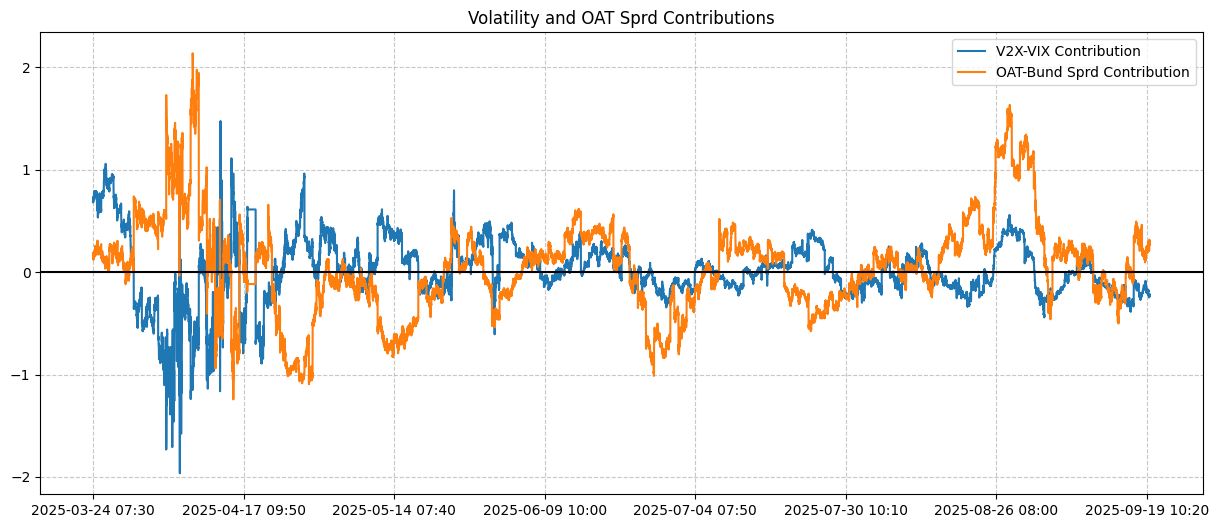

In [10]:
test1 = test[["Actual Main-IG", "Old Main-IG", "Const.", "V2X - VIX coef.", "V2X - VIX", "OAT-Bund Sprd coef.", "OAT-Bund Sprd"]].copy()

test1.loc[:, "Actual Main-IG"] = test1["Actual Main-IG"] + test1["Old Main-IG"]
test1.loc[:, "VIX Contribution"] = test1["V2X - VIX coef."] * test1["V2X - VIX"]
test1.loc[:, "OAT Sprd Contribution"] = test1["OAT-Bund Sprd coef."] * test1["OAT-Bund Sprd"]
test1 = test1[["Actual Main-IG","Old Main-IG","Const.","VIX Contribution","OAT Sprd Contribution"]]
test1 = test1[test1.index>datetime.now()-timedelta(days=6*30)] ################################## Last 4months
test1.index = [str(item)[:-3] for item in test1.index]
test1.columns = test1.columns.str.replace("VIX Contribution","V2X-VIX Contribution").\
    str.replace("OAT Sprd Contribution","OAT-Bund Sprd Contribution")
ax=test1[["V2X-VIX Contribution","OAT-Bund Sprd Contribution"]].plot(figsize=(15,6))
ax.axhline(0,color="black")
plt.title("Volatility and OAT Sprd Contributions")
ax.grid(which='major', axis='both', linestyle='--', alpha=0.7)
plt.savefig("Plots2.png")
# plt.xticks(rotation=45)
plt.show()

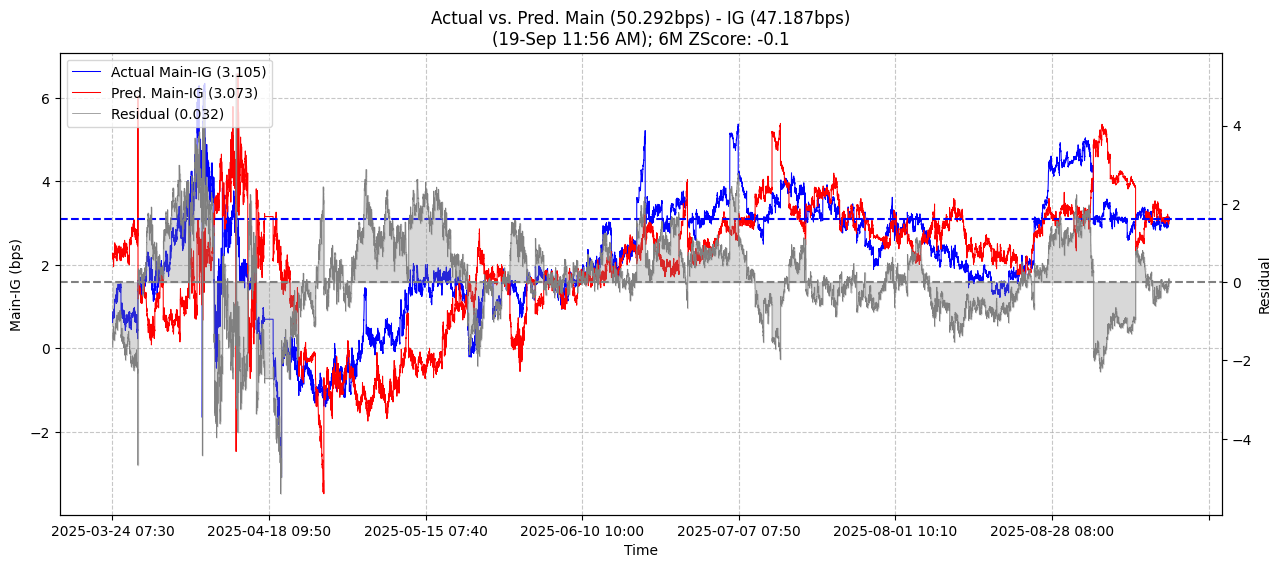

In [11]:
last_main = back.loc[df1.index[-1], "Main"]
last_ig = back.loc[df1.index[-1], "IG"]

actual_last = last_main-last_ig#df["Actual Main-IG"].iloc[-1]
pred_last = df["Pred. Main-IG"].iloc[-1]
last_residual = df["Residual"].iloc[-1]

ax = df[["Actual Main-IG", "Pred. Main-IG"]].plot(figsize=(15, 6), color=["blue", "red"], linewidth=0.75, legend=False)
ax.axhline(y=actual_last, color="blue", linestyle="--")

main_handles = [
    plt.Line2D([], [], color='blue', linewidth=0.75, label=f"Actual Main-IG ({actual_last:.3f})"),
    plt.Line2D([], [], color='red', linewidth=0.75, label=f"Pred. Main-IG ({pred_last:.3f})")
]

df["Residual"].plot(secondary_y=True, ax=ax, color="gray", linewidth=0.5, legend=False)
ax.right_ax.axhline(y=0, color='gray', linestyle='--')
ax.right_ax.fill_between(df.index, df["Residual"], 0, color='gray', alpha=0.3)
residual_handle = plt.Line2D([], [], color='gray', linewidth=0.5, label=f"Residual ({round(last_residual, 3)})")

ax.set_ylabel("Main-IG (bps)")
ax.right_ax.set_ylabel("Residual")
ax.set_xlabel("Time")

ax.grid(which='major', axis='both', linestyle='--', alpha=0.7)

plt.title(f"Actual vs. Pred. Main ({last_main:.3f}bps) - IG ({last_ig:.3f}bps)\n"
          f"({old_df.index[-1].strftime('%d-%b %I:%M %p')}); 6M ZScore: {round(zscore, 1)}")
plt.legend(handles=main_handles + [residual_handle], loc="upper left")
plt.savefig("Plots.png")
plt.show()


In [12]:
import os
import win32com.client

folder_path = r'J:\7A. IG-Main Email'

images = [f for f in os.listdir(folder_path) if f.endswith('.png')]

outlook = win32com.client.Dispatch("Outlook.Application")
mail = outlook.CreateItem(0)

html_body = '<html><body>'
for j, image in enumerate(images):
    file_path = os.path.join(folder_path, image)
    if os.path.exists(file_path):
        cid = f'image{j}'  # Create a unique CID for each image
        attachment = mail.Attachments.Add(Source=file_path)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", cid)
        html_body += f'<br><br><img src="cid:{cid}"><br>'
    else:
        print(f"File {file_path} not found")

html_body += '</body></html>'
mail.HTMLBody = html_body

mail.Subject = 'Main-IG (auto)'
mail.CC = 'vasu.sharma@iiicm.com'
if email_both:
    mail.To = 'spyros.michas@iiicm.com'
if send_email:
    mail.Send()
print("Email sent successfully")

Email sent successfully
